# Allstate claims severity - Kaggle challenge

## Goal 
### Assesment of insurance claim loss (severity of the given case) based on anonymized data about the claim. We are solving a regression problem.

## Intro
When you’ve been devastated by a serious car accident, your focus is on the things that matter the most: family, friends, and other loved ones. Pushing paper with your insurance agent is the last place you want your time or mental energy spent. This is why Allstate, a personal insurer in the United States, is continually seeking fresh ideas to improve their claims service for the over 16 million households they protect. Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims. In this recruitment challenge, Kagglers are invited to show off their creativity and flex their technical chops by creating an algorithm which accurately predicts claims severity. Aspiring competitors will demonstrate insight into better ways to predict claims severity for the chance to be part of Allstate’s efforts to ensure a worry-free customer experience...

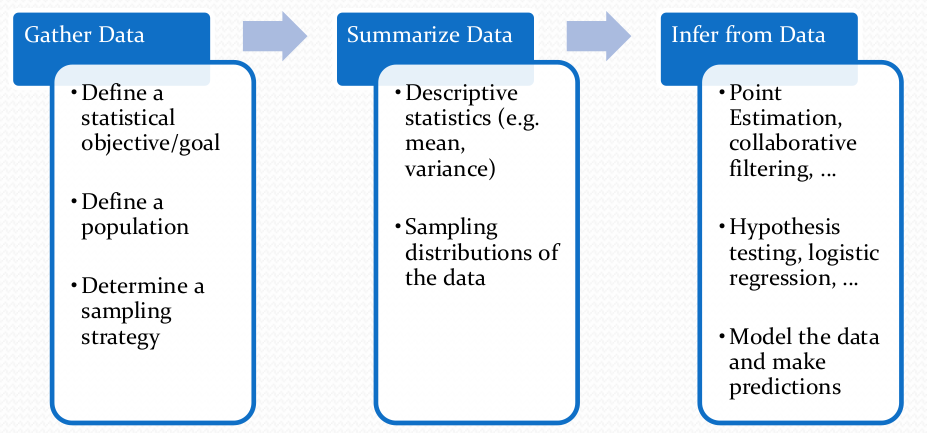

## Content:
1. Housekeeping and Imports
2. Data Loading
3. Data Exploration
4. Data Cleaning
5. Feature Engineering
6. Data Transformation and Preparation
7. Model Exploration and Performance Analysis
8. Final Model Building
9. Prediction on test set


## 1. Housekeeping and Imports

For importing libraries necessary for the project, and for basic preprocessing functions (ex: typset conversion for NLP projects). 

In [1]:
install.packages('data.table')
install.packages('Matrix')
install.packages('Metrics')
install.packages("xgboost")
install.packages("corrplot")
install.packages("magrittr")
install.packages("tidyverse")
install.packages("gridExtra")

Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)
Installing package into ‘/home/adri/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


In [2]:
library(data.table)
library(Matrix)
library(xgboost)
library(Metrics)
library(magrittr)
library(ggplot2)
library(tidyverse)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.4
✔ tidyr   0.8.0     ✔ dplyr   0.7.4
✔ readr   1.1.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks Matrix::expand()
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::set_names() masks magrittr::set_names()
✖ dplyr::slice()     masks xgboost::slice()
✖ purrr::transpose() masks data.table::transpose()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



## 2. Data Loading

For loading data files into appropriate variables.

In [52]:
ID = 'id'
TARGET = 'loss'
SEED = 0

TRAIN_FILE = "../train.csv"
TEST_FILE = "../test.csv"
SUBMISSION_FILE = "../sample_submission.csv"

# Reads a file in table format and creates a data frame from it, 
# with cases corresponding to lines and variables to fields in the file.

train = fread(TRAIN_FILE, showProgress = TRUE)
train$id = NULL
test = fread(TEST_FILE, showProgress = TRUE)

## 3. Data Exploration

### Example Records

In [4]:
head(train, n = 10)

cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,⋯,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
A,B,A,B,A,A,A,A,B,A,⋯,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
A,B,A,A,A,A,A,A,B,B,⋯,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
A,B,A,A,B,A,A,A,B,B,⋯,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
B,B,A,B,A,A,A,A,B,A,⋯,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
A,B,A,B,A,A,A,A,B,B,⋯,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
A,B,A,A,A,A,A,A,B,A,⋯,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
A,A,A,A,B,A,A,A,A,A,⋯,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
A,B,A,B,A,A,A,A,B,A,⋯,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
A,B,B,B,B,A,A,A,B,B,⋯,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
A,B,A,A,B,B,A,A,B,A,⋯,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [5]:
dim(train) # dimensions of train data

[1] 188318    131

### Data-types conversion

In [6]:
sapply(train, class) # data types of each feature

cat1        cat2        cat3        cat4        cat5        cat6 
"character" "character" "character" "character" "character" "character" 
       cat7        cat8        cat9       cat10       cat11       cat12 
"character" "character" "character" "character" "character" "character" 
      cat13       cat14       cat15       cat16       cat17       cat18 
"character" "character" "character" "character" "character" "character" 
      cat19       cat20       cat21       cat22       cat23       cat24 
"character" "character" "character" "character" "character" "character" 
      cat25       cat26       cat27       cat28       cat29       cat30 
"character" "character" "character" "character" "character" "character" 
      cat31       cat32       cat33       cat34       cat35       cat36 
"character" "character" "character" "character" "character" "character" 
      cat37       cat38       cat39       cat40       cat41       cat42 
"character" "character" "character" "character" "character" "character" 
      cat43       cat44       cat45       cat46       cat47       cat48 
"character" "character" "character" "character" "character" "character" 
      cat49       cat50       cat51       cat52       cat53       cat54 
"character" "character" "character" "character" "character" "character" 
      cat55       cat56       cat57       cat58       cat59       cat60 
"character" "character" "character" "character" "character" "character" 
      cat61       cat62       cat63       cat64       cat65       cat66 
"character" "character" "character" "character" "character" "character" 
      cat67       cat68       cat69       cat70       cat71       cat72 
"character" "character" "character" "character" "character" "character" 
      cat73       cat74       cat75       cat76       cat77       cat78 
"character" "character" "character" "character" "character" "character" 
      cat79       cat80       cat81       cat82       cat83       cat84 
"character" "character" "character" "character" "character" "character" 
      cat85       cat86       cat87       cat88       cat89       cat90 
"character" "character" "character" "character" "character" "character" 
      cat91       cat92       cat93       cat94       cat95       cat96 
"character" "character" "character" "character" "character" "character" 
      cat97       cat98       cat99      cat100      cat101      cat102 
"character" "character" "character" "character" "character" "character" 
     cat103      cat104      cat105      cat106      cat107      cat108 
"character" "character" "character" "character" "character" "character" 
     cat109      cat110      cat111      cat112      cat113      cat114 
"character" "character" "character" "character" "character" "character" 
     cat115      cat116       cont1       cont2       cont3       cont4 
"character" "character"   "numeric"   "numeric"   "numeric"   "numeric" 
      cont5       cont6       cont7       cont8       cont9      cont10 
  "numeric"   "numeric"   "numeric"   "numeric"   "numeric"   "numeric" 
     cont11      cont12      cont13      cont14        loss 
  "numeric"   "numeric"   "numeric"   "numeric"   "numeric"

In [7]:
train <- train %>% mutate_if(is.character,as.factor) # conversion of categorical type from character to factor
test <- test %>% mutate_if(is.character,as.factor)

### Missing values

In [8]:
if (sum(is.nan(as.matrix(train)))==0){
    print('No Values Missing')
}

[1] "No Values Missing"


### Descriptive Statistics

In [9]:
summary(train)

 cat1       cat2       cat3       cat4       cat5       cat6       cat7      
 A:141550   A:106721   A:177993   A:128395   A:123737   A:131693   A:183744  
 B: 46768   B: 81597   B: 10325   B: 59923   B: 64581   B: 56625   B:  4574  
                                                                             
                                                                             
                                                                             
                                                                             
                                                                             
 cat8       cat9       cat10      cat11      cat12      cat13      cat14     
 A:177274   A:113122   A:160213   A:168186   A:159825   A:168851   A:186041  
 B: 11044   B: 75196   B: 28105   B: 20132   B: 28493   B: 19467   B:  2277  
                                                                             
                                                                

We can see that some continous variables have a very big variation between median and mean which means that there are outliers available in the dataset.

### Standard deviation of variables

In [10]:
# This calculates the standard deviation for each numeric attribute in the dataset.
sapply(train[,118:131], sd)

cont2        cont3        cont4        cont5        cont6        cont7 
   0.2072017    0.2021046    0.2112922    0.2090268    0.2052726    0.1784502 
       cont8        cont9       cont10       cont11       cont12       cont13 
   0.1993705    0.1816602    0.1858767    0.2097365    0.2094266    0.2127772 
      cont14         loss 
   0.2224875 2904.0861864

### Visualizaton: Distribution of features

#### Bar charts for categorical variables distribution

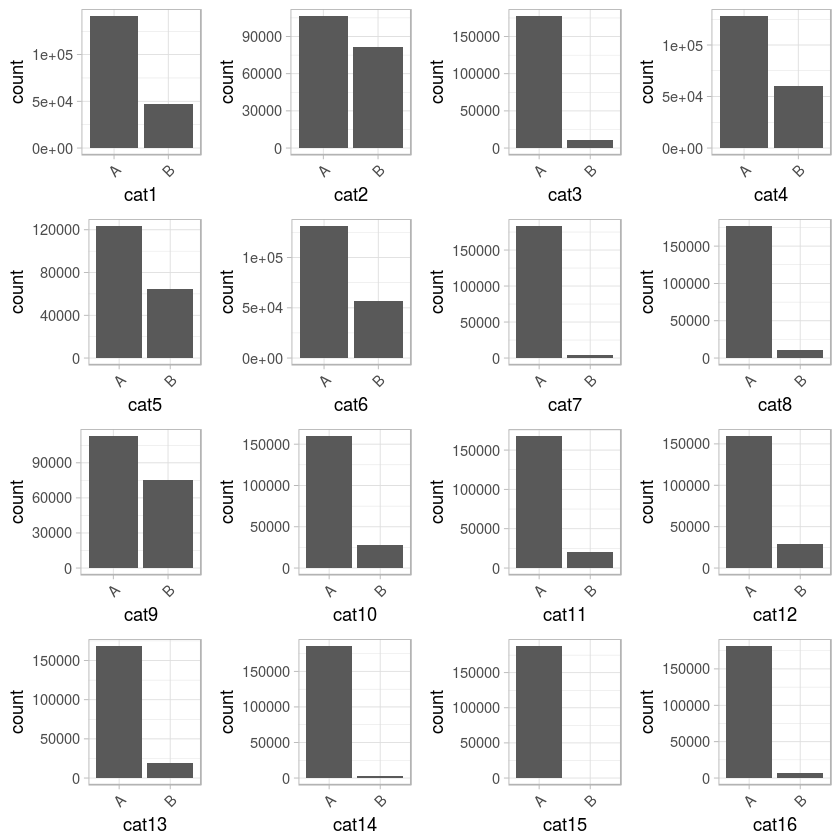

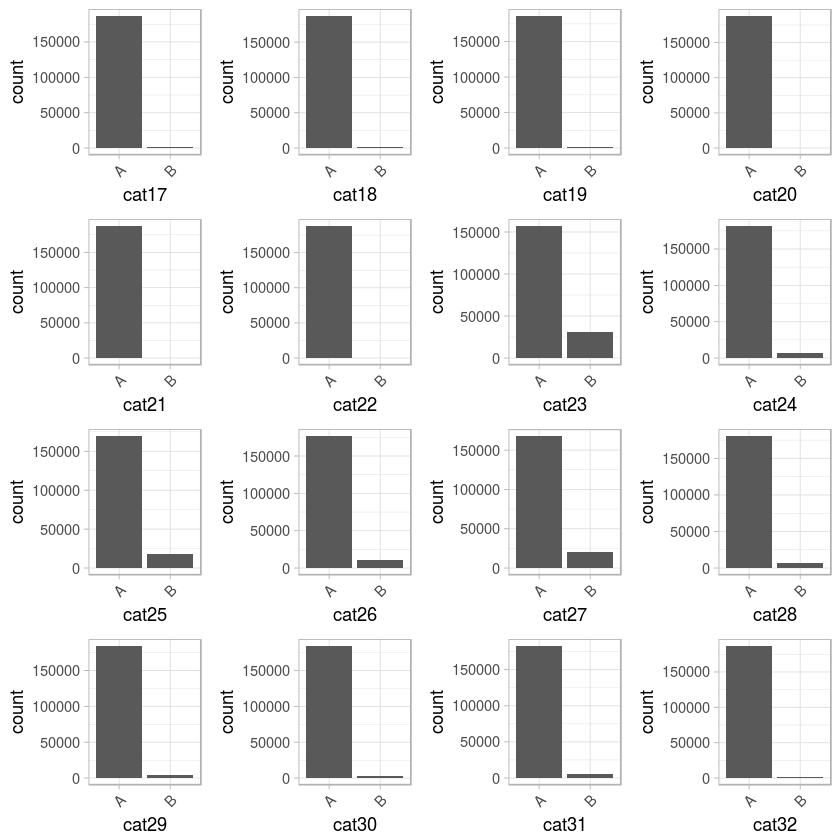

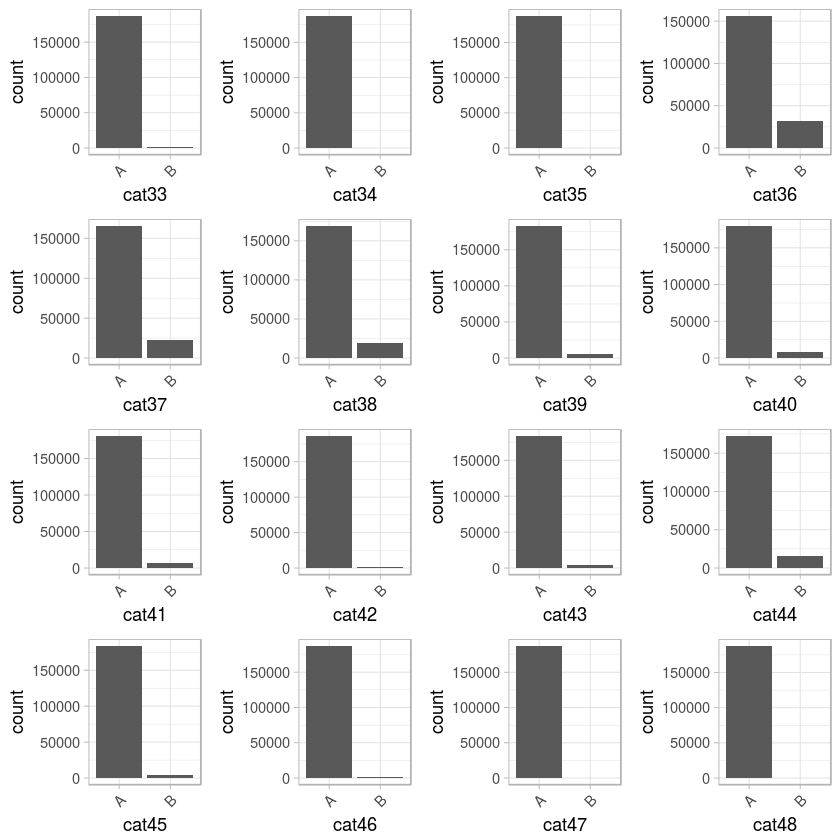

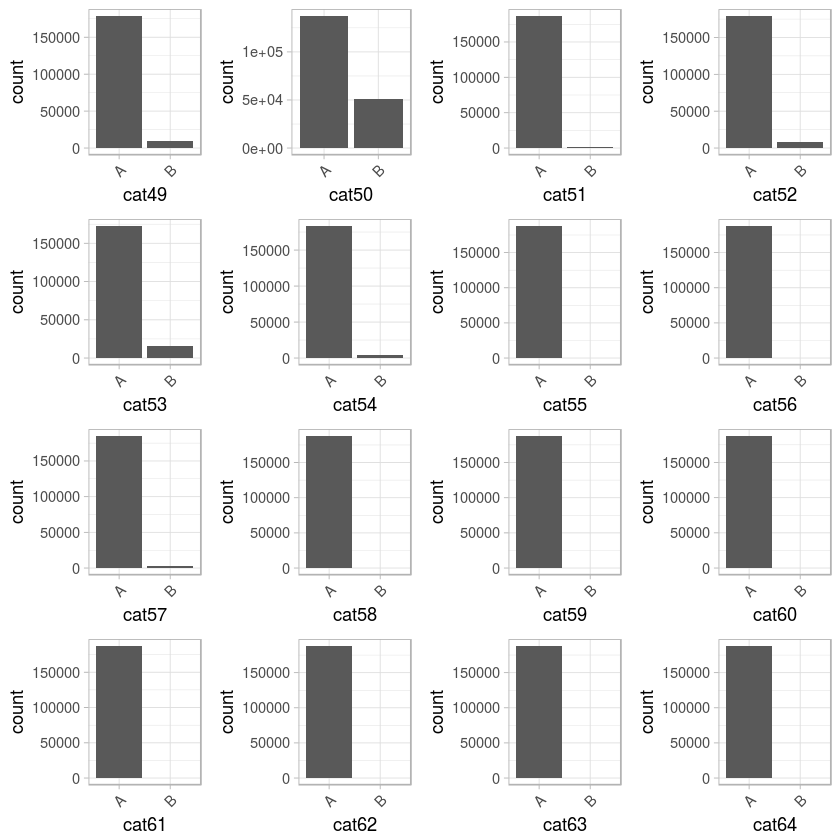

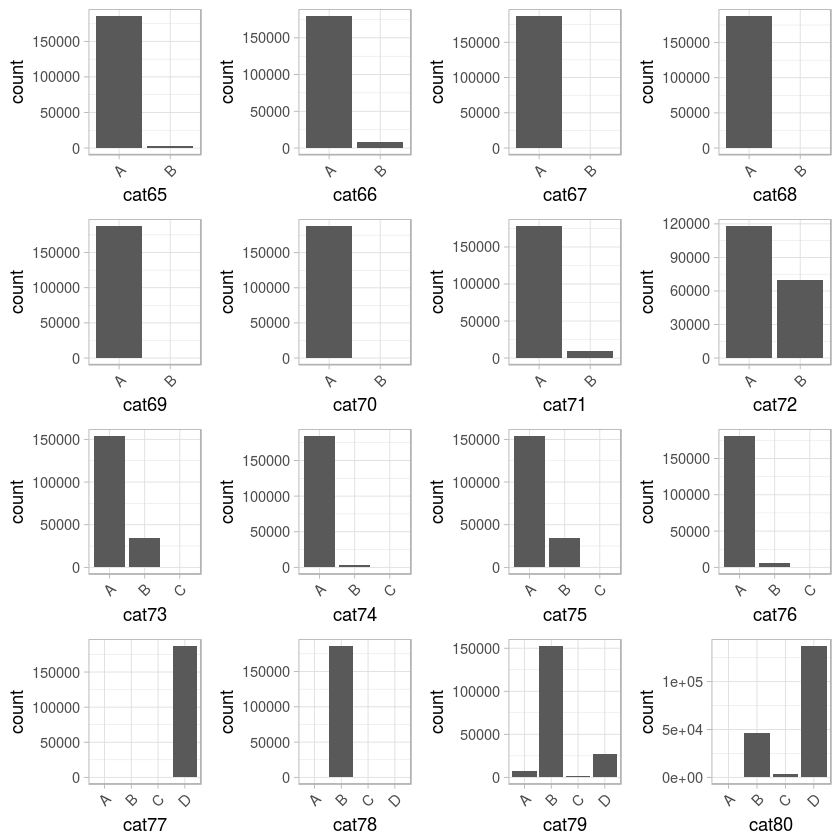

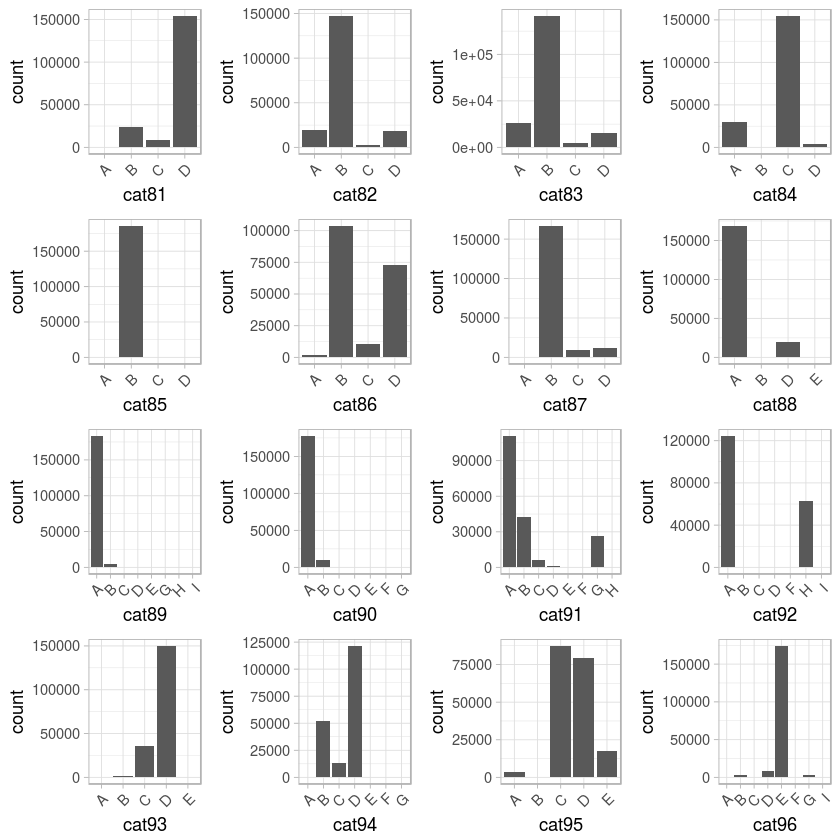

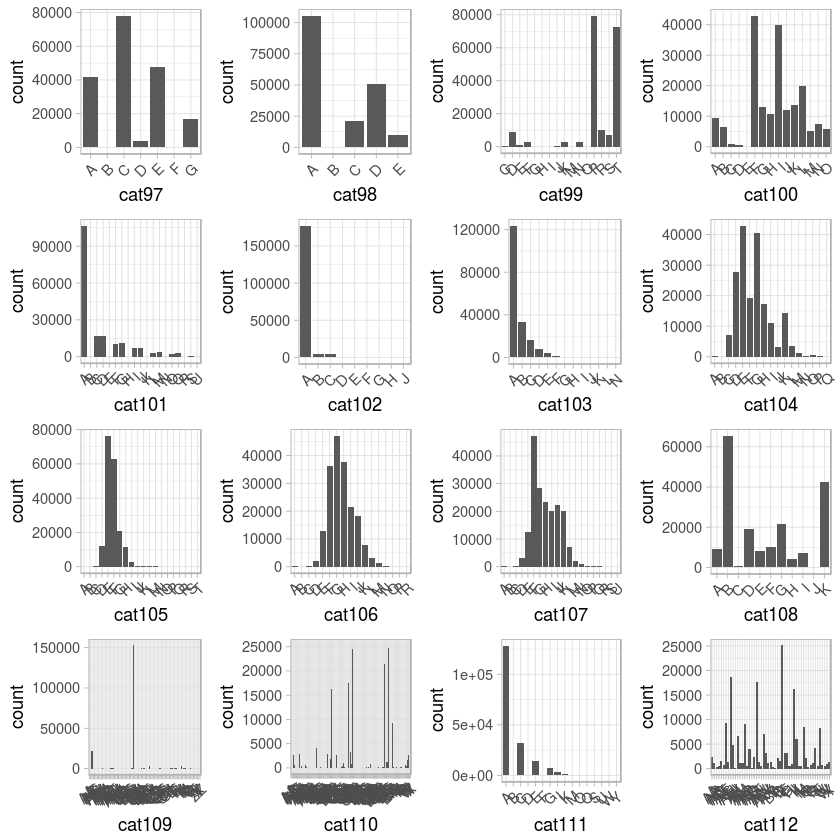

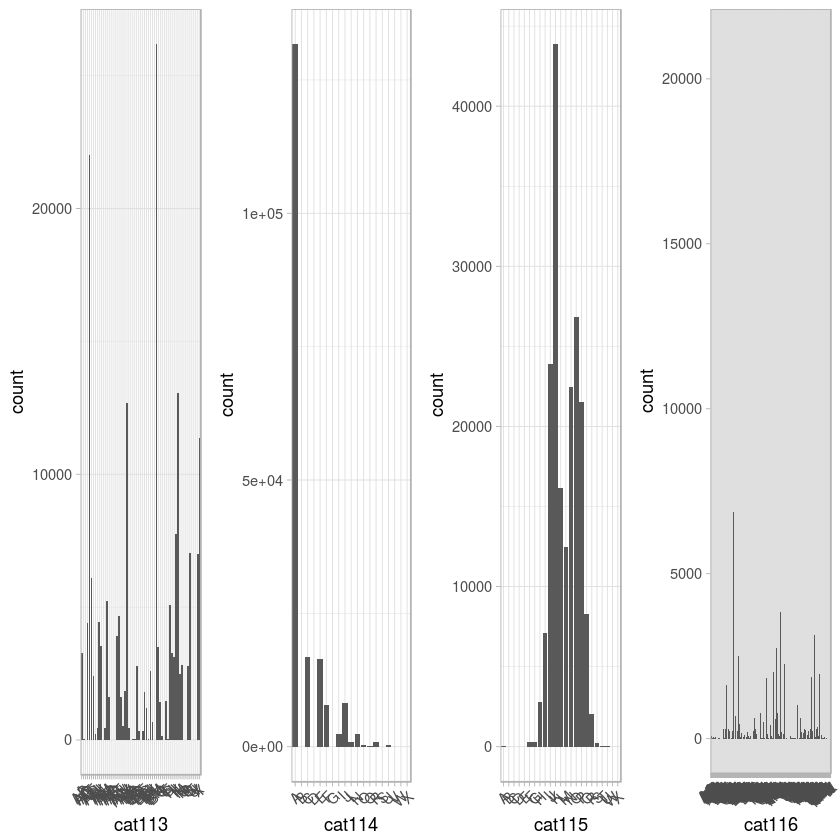

In [11]:
plotHist <- function(data_in, i) {
  data <- data.frame(x=data_in[[i]])
  p <- ggplot(data=data, aes(x=factor(x))) + stat_count() + xlab(colnames(data_in)[i]) + theme_light() + 
    theme(axis.text.x = element_text(angle = 45, hjust =1))
  return (p)
}

doPlots <- function(data_in, fun, ii, ncol=3) {
  pp <- list()
  for (i in ii) {
    p <- fun(data_in=data_in, i=i)
    pp <- c(pp, list(p))
  }
  do.call("grid.arrange", c(pp, ncol=ncol))
}

doPlots(train, fun = plotHist, ii = 1:16, ncol = 4)    
doPlots(train, fun = plotHist, ii = 17:32, ncol = 4)    
doPlots(train, fun = plotHist, ii = 33:48, ncol = 4)    
doPlots(train, fun = plotHist, ii = 49:64, ncol = 4)    
doPlots(train, fun = plotHist, ii = 65:80, ncol = 4)    
doPlots(train, fun = plotHist, ii = 81:96, ncol = 4)    
doPlots(train, fun = plotHist, ii = 97:112, ncol = 4)    
doPlots(train, fun = plotHist, ii = 113:116, ncol = 4) 

#### Histograms for continous variables

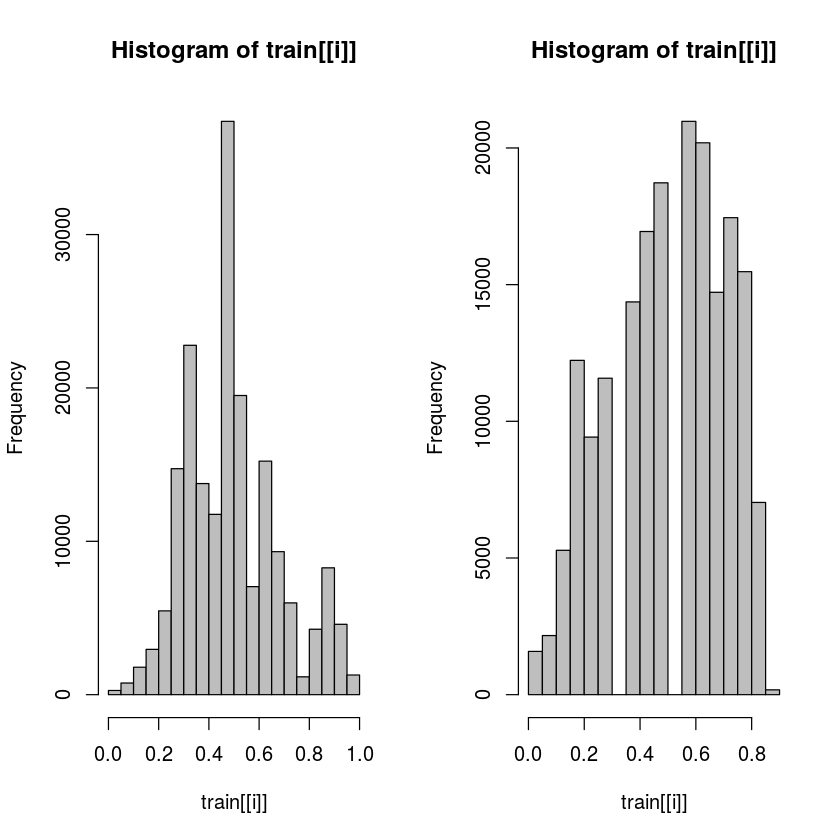

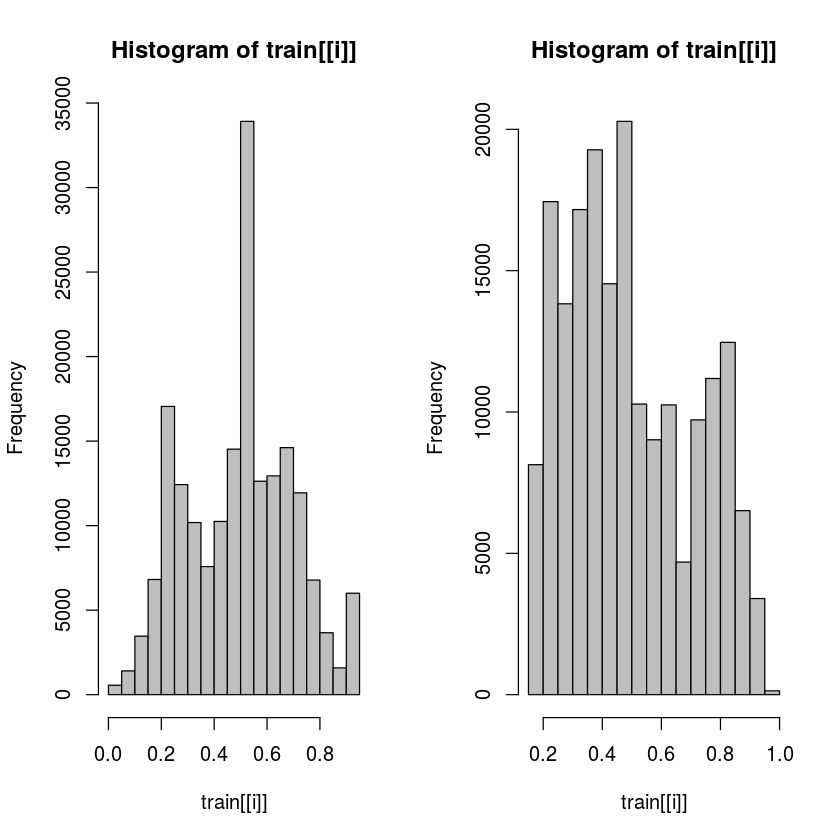

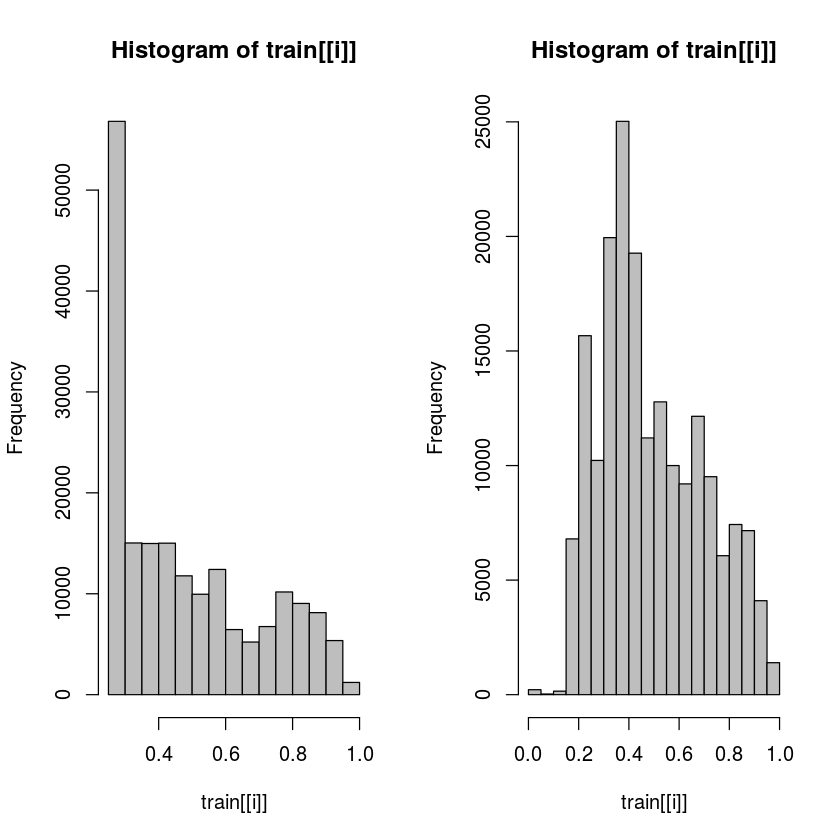

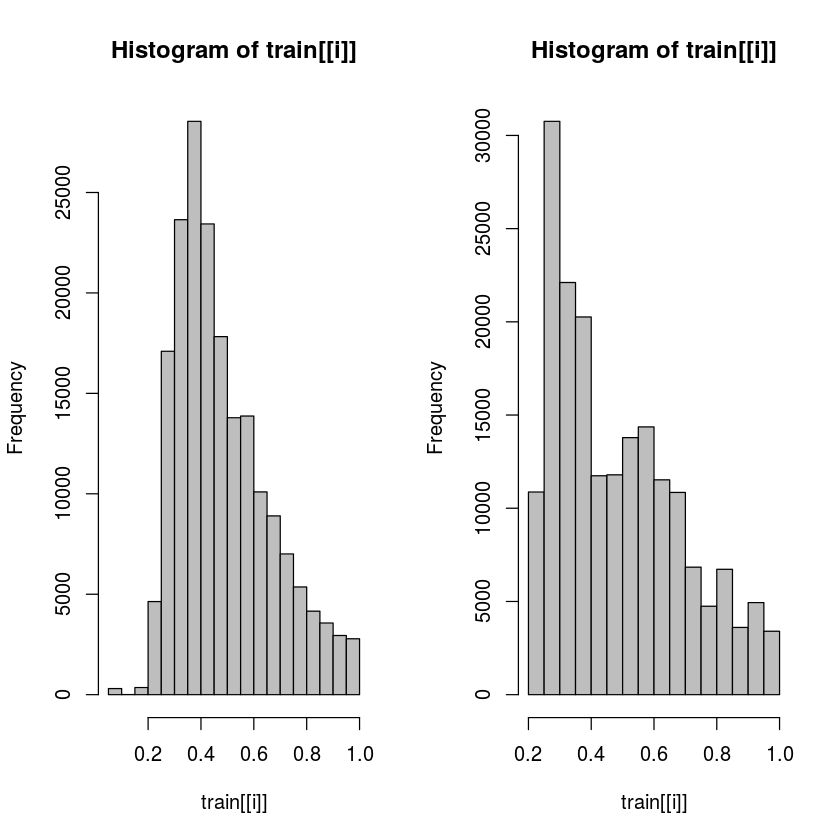

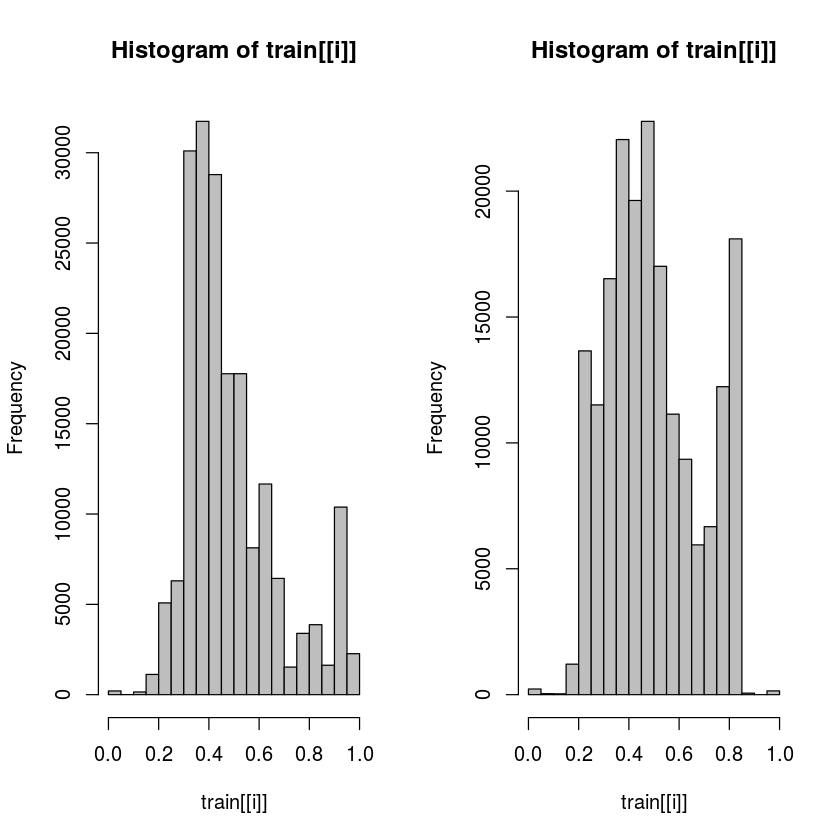

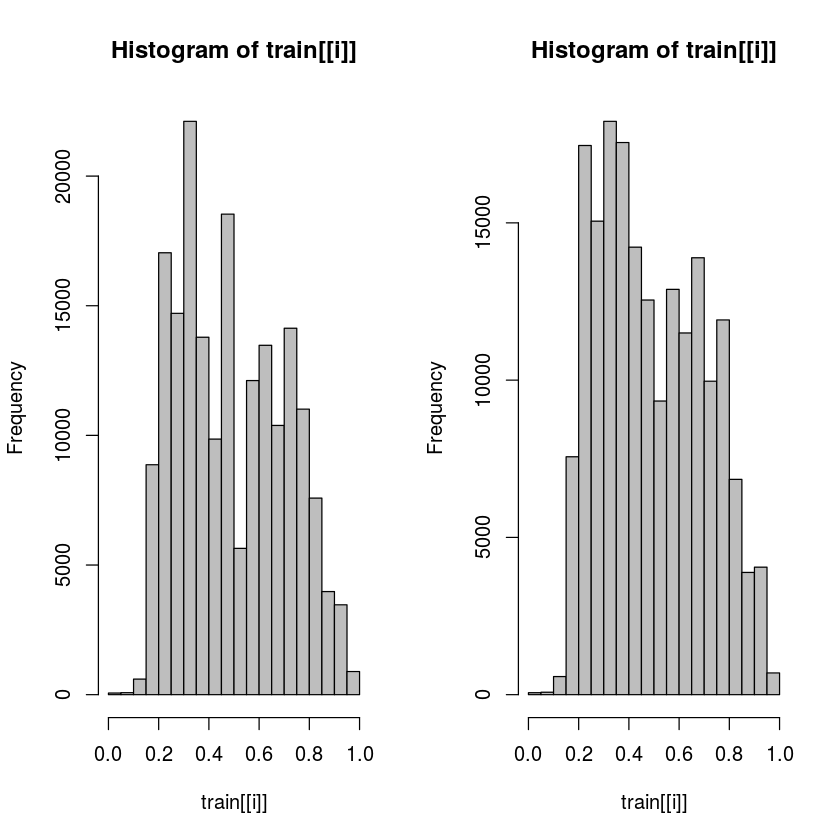

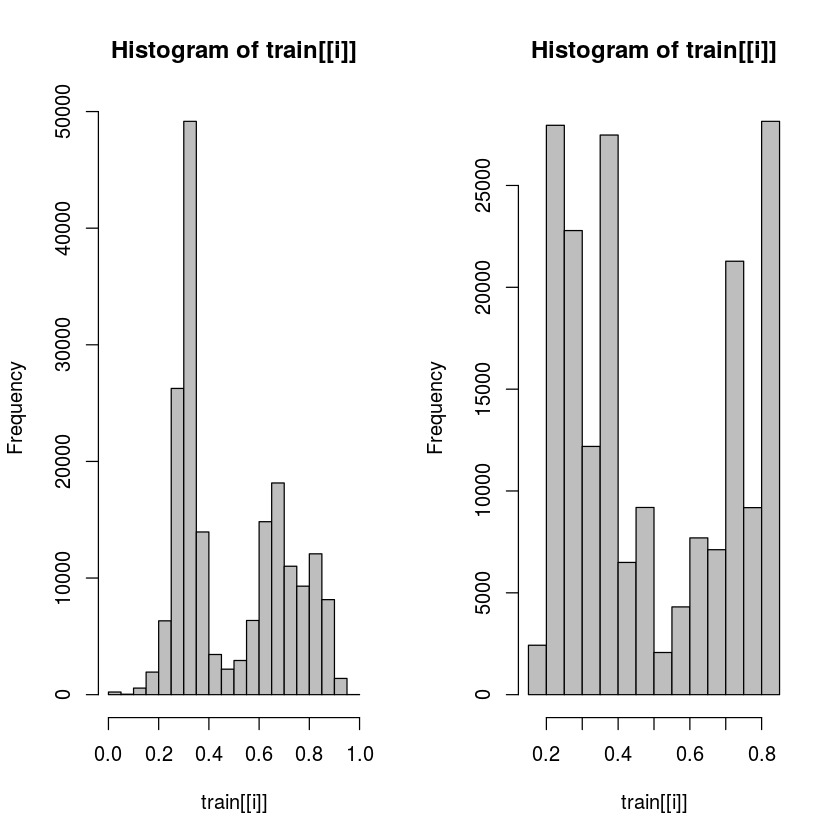

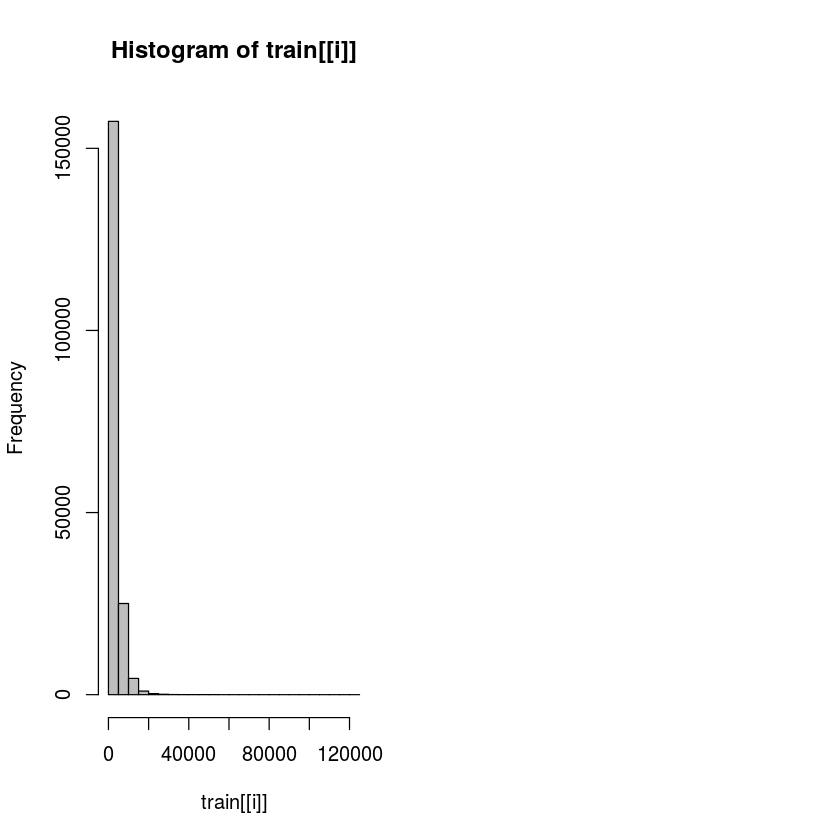

In [12]:
par(mfrow=c(1,2))
for (i in 117:131) {
    hist(train[[i]], col="grey") #generate hist
}

#### Loss variable distribution and Box plots for continous variables

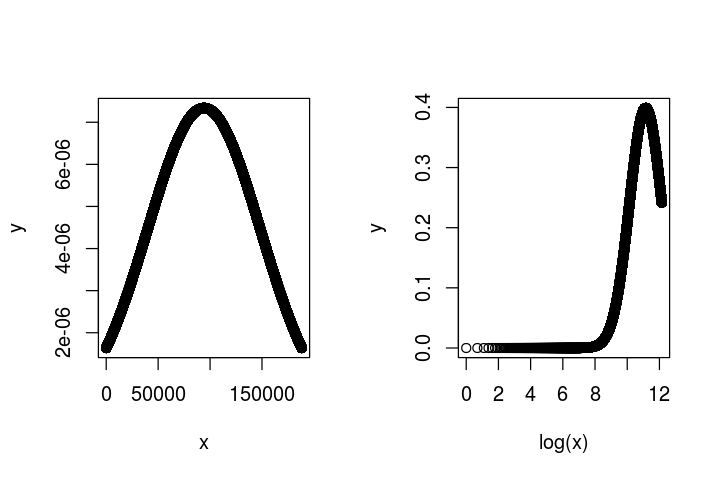

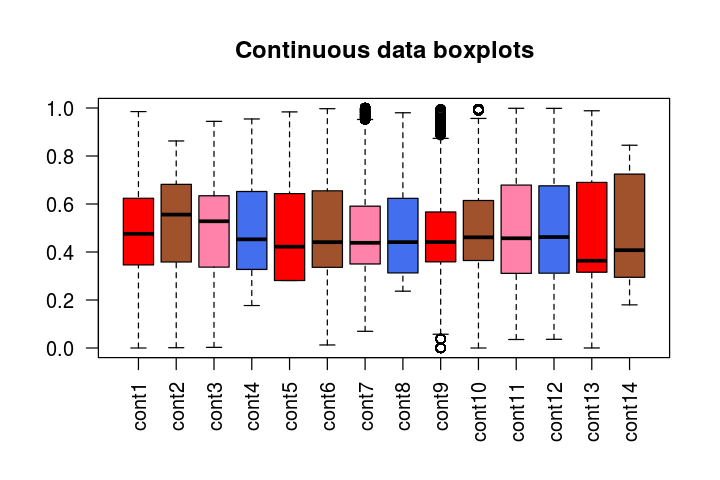

In [13]:
#extract continuous variables
dfCont = data.frame(row.names=1:nrow(train))
for(i in 1:length(train)){
    if (sapply(train[i], is.numeric) == TRUE){
        #contCol = list.append(contCol,head(df[i],n=0))
        dfCont = cbind(dfCont,train[i])
        }
    }

##check if the loss column has normal distribution - yes it has
x = dfCont['loss']
loss = dfCont['loss']
x = seq(x[-1,])
y = dnorm(x, mean = mean(x), sd = sd(x))
par(mfrow=c(1,2))
options(repr.plot.width=6, repr.plot.height=4)
plot(x,y)

#apply lognormal to reduce the scale and control negative values
y = dnorm(log(x), mean = mean(log(x)), sd = sd(log(x)))
plot(log(x),y)

#get the categorical values
dfAlph = data.frame(row.names=1:nrow(train))
for(i in 1:length(train)){
    if (sapply(train[i], is.numeric) == FALSE){
        #contCol = list.append(contCol,head(df[i],n=0))
        dfAlph = cbind(dfAlph,train[i])
        }
    }

#draw boxplots for them
#delete loss column or else huge outliers there
dfCont[length(dfCont)] = NULL
par(mfrow=c(1,1))
boxplot(dfCont, las=2, main="Continuous data boxplots", col=c("red","sienna","palevioletred1","royalblue2","red","sienna","palevioletred1","royalblue2","red","sienna","palevioletred1","royalblue2"))


### Investigating correlations between features

corrplot 0.84 loaded


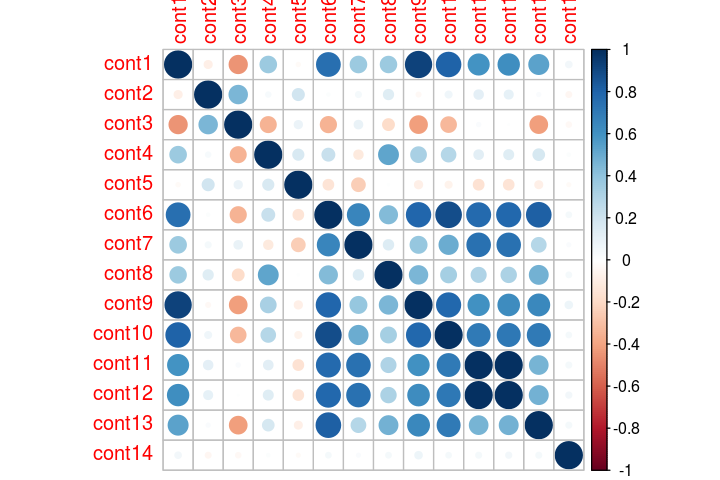

In [14]:
#correlation between continuous features including loss
scaled.dfCont = scale(dfCont)     #normalize
#zVar <- (corrM - mean(corrM)) / sd(corrM)     #z-transformation
corrM = cor(dfCont)
library(corrplot)
corrplot(corrM, method="circle")

We can see that many variables are highly correlated with each others this means that we can reduce number of continous variables for example using PCA.

### Outlier Detection

The presence of outliers can often skew results which take into consideration these data points. 

One approach to detect outliers is to use Tukey's Method for identfying them: An outlier step is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

## 4. Data Cleaning

Outliers might affect the output of an algorithm, that why it is important to investigate their influence on the model creation. For this purpose we identified outliers and created two models including and excluding outliers.

In case of severity claims in insurance company we can be sure that assesment of an accident had been performed carefully especially in the case of upper-bound correct outstanding values that resamble very severe case we should not ignore those cases but we have no knowledge about how the data was collected so we cannot assume that the data is error-free for for example typing errors.

We will remove Outliers using Tukey's rule:

In [15]:
removeOutliers <- function(x) {
    ## Find 25% and 75% Quantiles using inbuild function
    quant <- quantile(x, probs=c(.25, .75), na.rm = TRUE)
  
    ## Find Interquantile range and multiply it by 1.5 
    ## to derive factor for range calculation
    H <- 1.5 * IQR(x, na.rm = TRUE)
    y <- x
  
    ## fill the outlier elements with NA
    y[x < (quant[1] - H)] <- NA
    y[x > (quant[3] + H)] <- NA
 
    return(y)
}

In [16]:
for(i in 1:length(dfCont)) {
    dfCont[[i]] <- removeOutliers(dfCont[[i]])
}

## 5. Feature Engineering

As the dataset is being anonimized we are not able to apply business knowledge to select specific features based on that, therefore we moved to the next step.

### How to choose categorical features for model?

The most meaningful approach is to merge categories by some prior knowledge about them. E.g. group cities to states / countries / continents. It's not the best approach from statistical perspective (it mixes good and bad cities together) but leads to the most understandable models (west coast is better than east, etc.).

The simplest approach (after just discarding the attribute) is to get top N categories (N<20) and put all others into separate category. Works well when top N categories have over 50% of total observations and you don't mind to lose some information value.

In other situations you can apply method what merges categories based on entropy. Calculate entropy (or weight of evidence, or simply odds or probability to 'yes') for all categories and merge those with similar levels. It works well for categories with at least hundreds of observations. Smaller categories are just a noise - where it may or may not work.

### Another idea is to use frequent pattern mining




1.    If all the sub-classes are significant: then you can take a look at the estimated coefficient and regroup those who have more or less the same level of estimated coefficient. The reason is that they have the same effect on the outcome.
2.    If the sub-classes are non-significant, the first thing to do is to verify if your categorical predictor is significant or not, by performing one model with this predictor, and one without, then do a likelihood ratio test. If your predictor is non-significant, exclude it from your model. If not, try to regroup your predictor in a meaningful way: for example: if Neighborhood is a significant predictor, there is likely an underlying factor, such as the income, try to regroup your predictor base on that.


## 6. Data Transformation and Preparation

### Transforming Skewed Continous Features 

It is common practice to apply a logarthmic transformation to highly skewed continuous feature distributions.

### Normalizing and Scaling Numerical Features 

One common practice is to perform some type of scaling on numerical features. Applying scaling doesn't change the shape of each feature's distribution; but ensures that each feature is treated equally when applying supervised learners.

In our case all of numerical features are already between 0 and 1 value so there is no need for scaling.

### One Hot Encoding Categorical Features

### Dimensionality reduction

### Shuffle and Split Data

Because test data provided by the orginizers are without corect loss we should split our train data set into train and test sets.

## 7. Model Exploration

### Gradient boosted decision trees

We tried out many kaggle kernels for this challenge and majority and once with best performance used XGBoost implementation of gradient boosted decision trees, that is why we decided to use this algorithm.

### Baseline model

#### Naive Predictor Performance

First naive baseline model would be to predict loss by taking the central measure of loss, so for each observation we will predict the mean of loss. 

In [53]:
loss = log(train$loss)
dummy_prediction = rep(mean(unlist(loss)),length(loss))

In [55]:
eval_mae <- function (yhat, y) {
   err= mae(exp(unlist(yhat)),exp(unlist(y)) )
   return(err)
}
print(eval_mae(dummy_prediction, loss))


[1] 1809.837


#### Multiple Linear Regression Model

#### XGBoost without feature engineering

In [ ]:
y_train = log(train$loss)
train$loss = NULL

ntrain = nrow(train)

features = names(train)

for (f in features) {
  if (class(train[[f]])=="character") {
    #cat("VARIABLE : ",f,"\n")
    levels <- unique(train[[f]])
    train[[f]] <- as.integer(factor(train[[f]], levels=levels))
  }
}

x_train = train[1:ntrain,]

dtrain = xgb.DMatrix(data.matrix(x_train), label=y_train)

xgb_params = list(
  seed = 0,
  colsample_bytree = 0.7,
  subsample = 0.7,
  eta = 0.08,
  objective = 'reg:linear',
  max_depth = 6,
  num_parallel_tree = 1,
  min_child_weight = 1,
  base_score = 7
)

xg_eval_mae <- function (yhat, dtrain) {
   y = getinfo(dtrain, "label")
   err= mae(exp(y),exp(yhat) )
   return (list(metric = "error", value = err))
}

res = xgb.cv(xgb_params,
             dtrain,
             nrounds=750,
             nfold=4,
             early_stopping_rounds=15,
             print_every_n = 10,
             verbose= 1,
             feval=xg_eval_mae,
             maximize=FALSE)

best_nrounds = res$best_iteration
cv_mean = res$evaluation_log$test_error_mean[best_nrounds]
cv_std = res$evaluation_log$test_error_std[best_nrounds]
cat(paste0('CV-Mean: ',cv_mean,' ', cv_std))

gbdt = xgb.train(xgb_params, dtrain, nrounds=best_nrounds, feval = xg_eval_mae, verbose = 1, maximize = F)

To set a baseline for the performance of the predictor. 

Common techniques:
- For categorical prediction vector, choose the most common class
- For numerical prediction vector, choose a measure of central tendency

Then calculate the evalation metric (accuracy, f-score etc)

### Choosing scoring metrics

To assess the correctness of our model we used MAE (Mean Absolute Error) which was an official metric for challenge model assesment and is given by the formula:

$$MAE = \sum_{i=1}^{n} \frac{|y_i - x_i|}{n}$$

### Creating a Training and Prediction Pipeline

### Model Evaluation

## 8. Final Model Building

Using grid search (GridSearchCV) with different parameter/value combinations, we can tune our model for even better results.

Next steps can include feature importance extraction, predictions on the test set.. etc

### Good model with feature grouping from kaggle kernel MAE: 1146

In [17]:
y_train = log(train$loss)
train$loss = NULL

ntrain = nrow(train)
attach(train)
train[c("cat12_cat80", "cat79_cat80", "cat57_cat80", "cat101_cat79", "cat57_cat79", "cat101_cat80")]<- list(
  paste(cat12, cat80, sep="_"),
  paste(cat79, cat80, sep="_"),
  paste(cat57, cat80, sep="_"),
  paste(cat101, cat79, sep="_"),
  paste(cat57, cat79, sep="_"),
  paste(cat101, cat80, sep="_")
)

train[c("cat101_cat79_cat81", "cat57_cat79_cat80", "cat103_cat12_cat80")] <- list(
  paste(cat101, cat79, cat81, sep="_"),
  paste(cat57, cat79, cat80, sep="_"),
  paste(cat103, cat12, cat80, sep="_")
)

features = names(train)

for (f in features) {
  if (class(train[[f]])=="character") {
    #cat("VARIABLE : ",f,"\n")
    levels <- unique(train[[f]])
    train[[f]] <- as.integer(factor(train[[f]], levels=levels))
  }
}

x_train = train[1:ntrain,]

dtrain = xgb.DMatrix(data.matrix(x_train), label=y_train)

xgb_params = list(
  seed = 0,
  colsample_bytree = 0.7,
  subsample = 0.7,
  eta = 0.08,
  objective = 'reg:linear',
  max_depth = 6,
  num_parallel_tree = 1,
  min_child_weight = 1,
  base_score = 7
)

xg_eval_mae <- function (yhat, dtrain) {
   y = getinfo(dtrain, "label")
   err= mae(exp(y),exp(yhat) )
   return (list(metric = "error", value = err))
}

res = xgb.cv(xgb_params,
             dtrain,
             nrounds=750,
             nfold=4,
             early_stopping_rounds=15,
             print_every_n = 10,
             verbose= 1,
             feval=xg_eval_mae,
             maximize=FALSE)

best_nrounds = res$best_iteration
cv_mean = res$evaluation_log$test_error_mean[best_nrounds]
cv_std = res$evaluation_log$test_error_std[best_nrounds]
cat(paste0('CV-Mean: ',cv_mean,' ', cv_std))

gbdt = xgb.train(xgb_params, dtrain, nrounds=best_nrounds, feval = xg_eval_mae, verbose = 1, maximize = F)



[1]	train-error:2029.765062+4.610991	test-error:2029.779769+12.636784 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't improved in 15 rounds.

[11]	train-error:1610.529180+3.495103	test-error:1612.708823+10.088137 
[21]	train-error:1380.485441+2.191250	test-error:1386.429723+9.095083 
[31]	train-error:1274.036653+1.232846	test-error:1284.050187+7.165855 
[41]	train-error:1221.014321+0.850407	test-error:1234.972852+5.639567 
[51]	train-error:1190.685741+0.889739	test-error:1208.452885+4.614002 
[61]	train-error:1171.158062+0.637771	test-error:1191.978676+4.390645 
[71]	train-error:1157.782919+0.887336	test-error:1181.549735+3.769969 
[81]	train-error:1148.153244+0.806179	test-error:1174.648553+3.601788 
[91]	train-error:1140.634284+1.287611	test-error:1169.768480+3.630288 
[101]	train-error:1134.337797+1.077372	test-error:1166.097010+3.613977 
[111]	train-error:1128.567583+1.047547	test-error:1162.993608+3.450171 
[121]	train

## 9. Predictions on Test Set

## 10. References

- Greedy Function Approximation: A Gradient Boosting Machine, by Friedman (https://statweb.stanford.edu/~jhf/ftp/trebst.pdf)